In [150]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from timeit import default_timer as timer

In [151]:
data_dir = 'C:/Users/Myles-PC/Source/Repos/ML/Traffic-Sign-Recognizer/archive'
train_path = 'C:/Users/Myles-PC/Source/Repos/ML/Traffic-Sign-Recognizer/archive/Train'
test_path = 'C:/Users/Myles-PC/Source/Repos/ML/Traffic-Sign-Recognizer/archive/'
IMG_HEIGHT = 30
IMG_WIDTH = 30

In [152]:
# Number of Classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [153]:
def from_input(path):
    return os.path.join(data_dir, path)
train_info = pd.read_csv(from_input("Train.csv"))
train_info.dataframeName = 'Trains.csv'
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [154]:
train_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


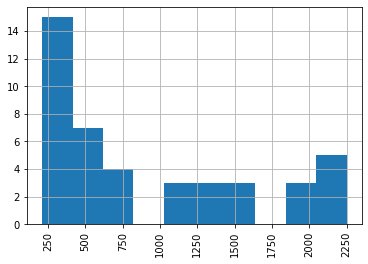

In [350]:
train_info.groupby('ClassId')['ClassId'].count().hist(xrot = 90)

In [156]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

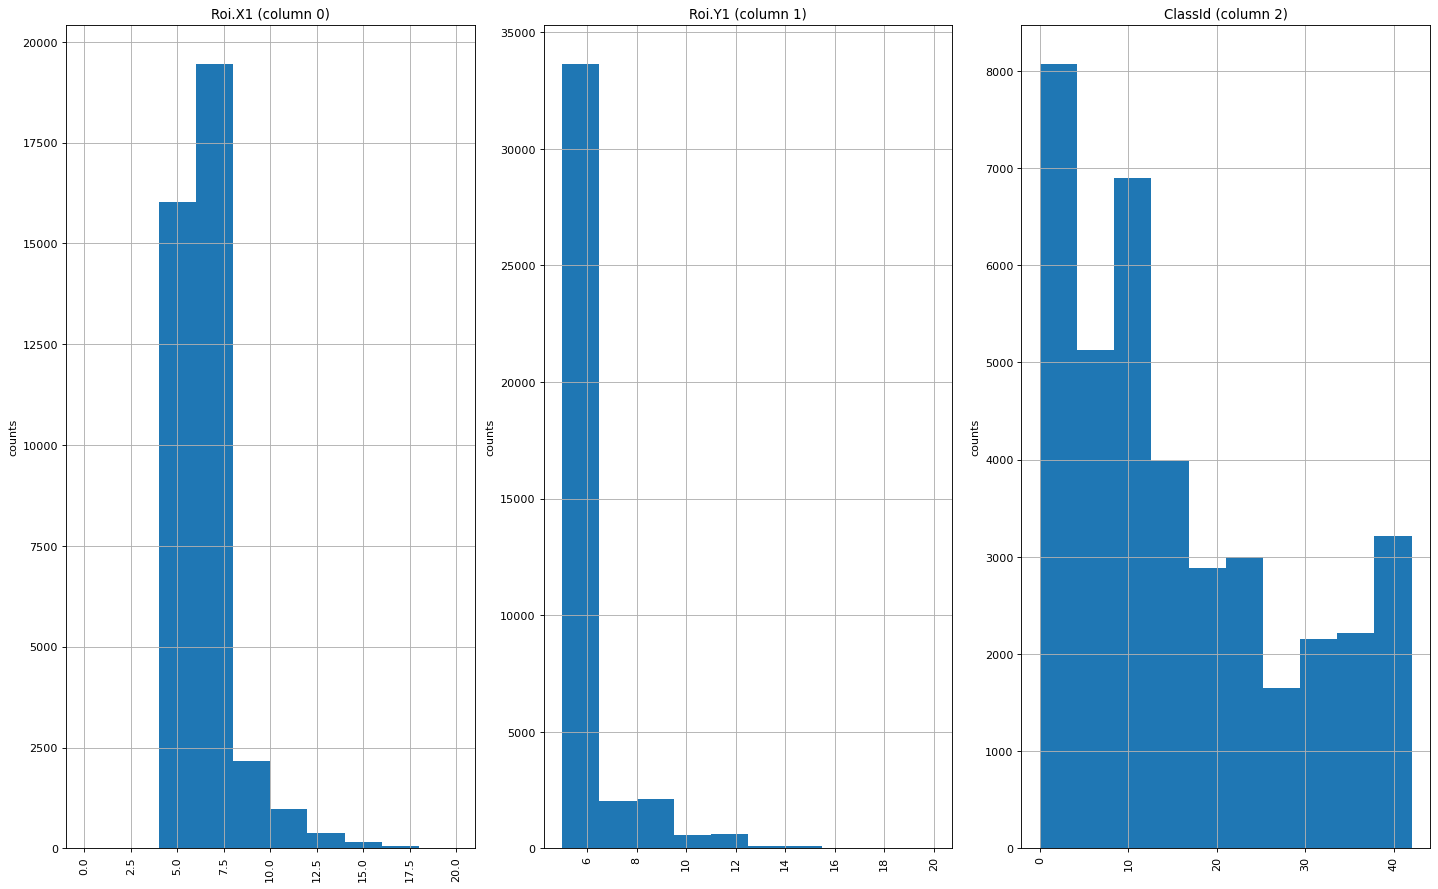

In [346]:

plotPerColumnDistribution(train_info, 10, 5)

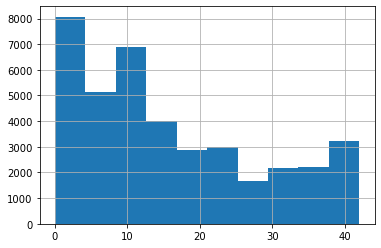

In [344]:
train_info['ClassId'].hist()

In [158]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

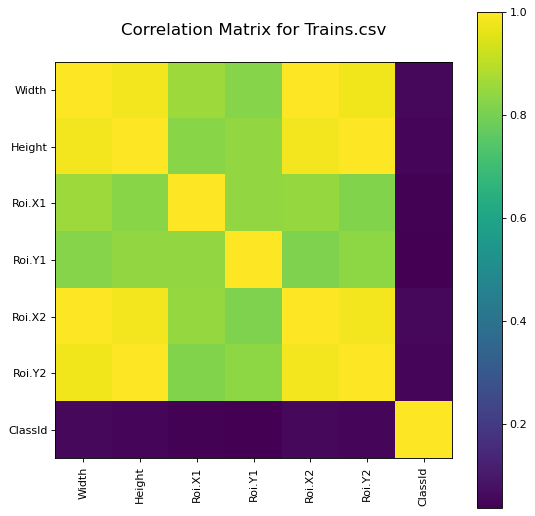

In [159]:
plotCorrelationMatrix(train_info, 8)

In [160]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

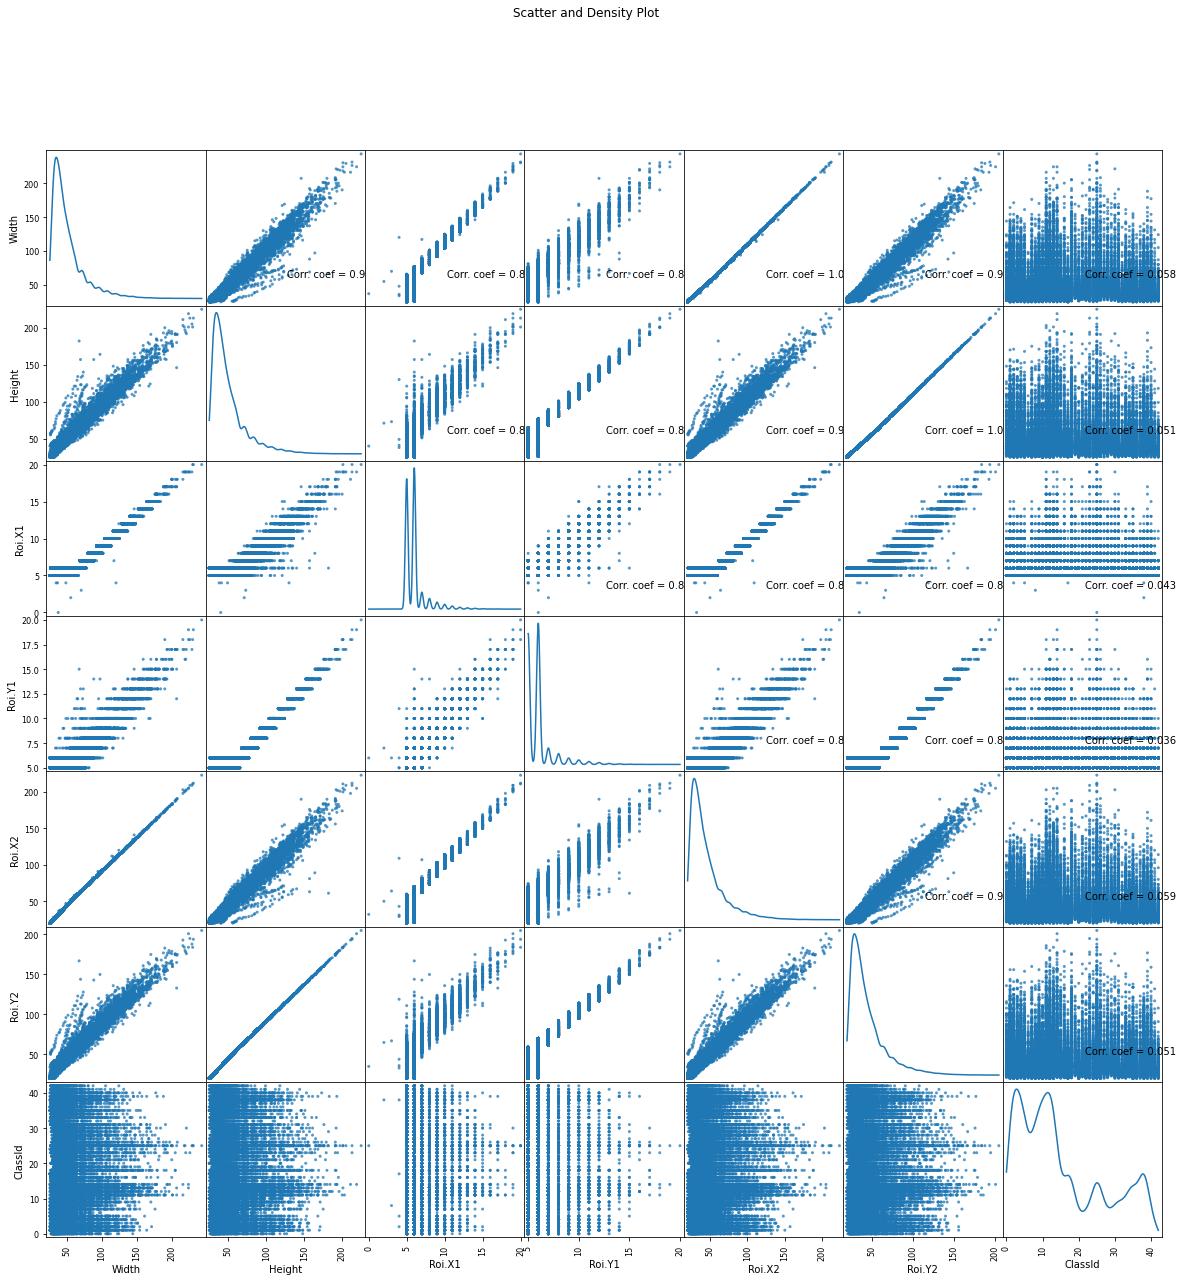

In [161]:
plotScatterMatrix(train_info, 20, 10)

In [162]:
TARGET_SIZE = (40, 40) # resizing size
FLATTEN_SIZE = TARGET_SIZE[0] * TARGET_SIZE[1] * 3
BATCH_SIZE=300

In [163]:
def preprocess (image):
    resize_image = tf.image.resize(image, (224, 224) )
    return resize_image

In [226]:
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]
y_train = to_categorical(y_train, 43)

train_data=[]


for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('train'), f.replace('Train/', '')), target_size=TARGET_SIZE)
    train_data.append(img_to_array(image))

print('Data loaded.              ')
        

Data loaded.              


In [227]:
print(y_train[0:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

In [228]:
print(train_data[0:10])

[array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [ 88.,  87.,  58.],
        [ 85.,  77.,  51.],
        [ 82.,  67.,  44.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [103.,  89.,  56.],
        [ 79.,  90.,  60.],
        [ 70.,  70.,  42.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [117.,  90.,  52.],
        [ 80., 110.,  82.],
        [ 41.,  56.,  37.]],

       ...,

       [[255., 255., 221.],
        [210., 217., 166.],
        [199., 214., 176.],
        ...,
        [178., 148.,  56.],
        [221., 187., 102.],
        [185., 140.,  61.]],

       [[255., 255., 236.],
        [194., 194., 188.],
        [242., 241., 237.],
        ...,
        [253., 233., 126.],
        [255., 247., 123.],
        [255., 251., 110.]],

       [[255., 255., 255.],
        [180., 172., 188.],
        [212., 

In [229]:


from sklearn.model_selection import train_test_split #For splitting data into training and test sets
x_train_df, x_validate_df, y_train_df, y_validate_df = train_test_split(train_data, y_train, test_size = 0.30)


In [236]:
print("x_train len = ", len(x_train_df), " y_train len = " , len(y_train_df))


x_train len =  27446  y_train len =  27446


In [238]:
print("x_validate len = ", len(x_validate_df), " y_validate len = ", len(y_validate_df))

x_validate len =  11763  y_validate len =  11763


In [239]:

x_train_df = tf.keras.applications.vgg16.preprocess_input(np.array(x_train_df))
x_validate_df = tf.keras.applications.vgg16.preprocess_input(np.array(x_validate_df))
train_data = None

In [240]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                    rotation_range = 15,
                                   width_shift_range = 0.18,
                                   height_shift_range = 0.18,
                                    horizontal_flip = True)

train_generator = train_datagen.flow(train_df,
                                     y_train_df,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)
                                         
                                         
                                         
validate_data_generator = ImageDataGenerator(
        rotation_range = 15,
        rescale=1.0/255.0, 
        width_shift_range = 0.18,
        height_shift_range = 0.18,
        horizontal_flip = True
)

validate_gen = validate_data_generator.flow(
        x_validate_df,
        y_validate_df,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=17
 )

In [241]:
test_info =  pd.read_csv(from_input("Test.csv"))
test_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [352]:
test_info.groupby('ClassId')['ClassId'].count()

ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: ClassId, dtype: int64

In [320]:
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

test_data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('test'), f.replace('Test/', '')), target_size=TARGET_SIZE)
    test_data.append(img_to_array(image))

print('Data loaded.              ')

Data loaded.              


In [336]:
X_test = tf.keras.applications.vgg16.preprocess_input(np.array(test_data))
test_data = None

In [326]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow(X_test,
                                    y_test,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)


In [283]:
IMG_SHAPE = TARGET_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 40, 40, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 40, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 40, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 20, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 20, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 20, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 10, 10, 128)       0     

In [284]:
for layer in base_model.layers:
    layer.trainable = False

In [285]:
VERBOSE=1

In [287]:
last_layer = base_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output



optimizer=Adam(learning_rate=0.01)
epochs=15

x = Flatten()(last_output)
x = Dropout(0.33)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.33)(x)
x = Dense(128, activation='relu')(x)
x = Dense(43, activation='softmax')(x)           

model = Model(base_model.input, x)


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = timer()
history = model.fit_generator(train_generator,
                    epochs=epochs,
                    verbose=VERBOSE,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=2)],
                    validation_data=validate_gen,
                    steps_per_epoch= round(x_train_df.shape[0] / BATCH_SIZE))
end_time = timer()

print('==============================')
print('Optimizer: ', optimizer.__class__.__name__)

print('Learning rate: ', optimizer.get_config()['learning_rate'])
print('Epochs: ', epochs)
print('==============================')
print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))

last layer output shape:  (None, 5, 5, 512)
Epoch 1/15
91/91 [==============================] - 335s 4s/step - loss: 6.6801 - accuracy: 0.1797 - val_loss: 2.0637 - val_accuracy: 0.3189
Epoch 2/15
91/91 [==============================] - 336s 4s/step - loss: 2.2423 - accuracy: 0.3042 - val_loss: 1.7486 - val_accuracy: 0.4172
Epoch 3/15
91/91 [==============================] - 336s 4s/step - loss: 2.0778 - accuracy: 0.3468 - val_loss: 1.6787 - val_accuracy: 0.4370
Epoch 4/15
91/91 [==============================] - 336s 4s/step - loss: 1.9846 - accuracy: 0.3707 - val_loss: 1.5995 - val_accuracy: 0.4648
Epoch 5/15
91/91 [==============================] - 337s 4s/step - loss: 1.9380 - accuracy: 0.3792 - val_loss: 1.5913 - val_accuracy: 0.4841
Epoch 6/15
91/91 [==============================] - 337s 4s/step - loss: 1.8904 - accuracy: 0.3944 - val_loss: 1.5972 - val_accuracy: 0.4704
Epoch 7/15
91/91 [==============================] - 337s 4s/step - loss: 1.8690 - accuracy: 0.3994 - val_loss:

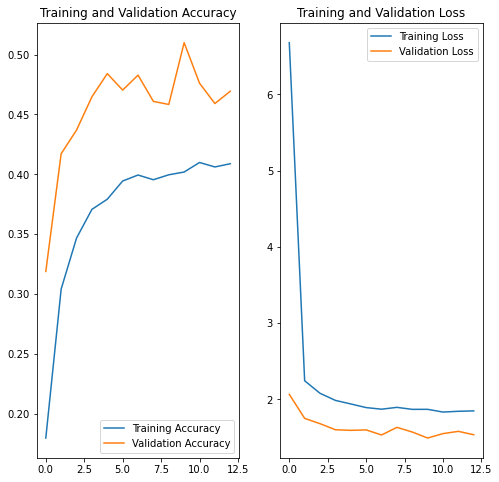

In [291]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [292]:
test_acc = model.evaluate(test_generator)[1]

43/43 [==============================] - 101s 2s/step - loss: 1.5268 - accuracy: 0.4850


In [357]:
valid_acc = model.evaluate(validate_gen)[1]

40/40 [==============================] - 155s 4s/step - loss: 0.6054 - accuracy: 0.8311


In [293]:
for layer in model.layers:
    layer.trainable = True

In [294]:
optimizer=Adam(learning_rate=0.0001)
epochs=10

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = timer()
history = model.fit_generator(train_generator,
                    epochs=epochs,
                    verbose=VERBOSE,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=2)],
                    validation_data=validate_gen,
                    steps_per_epoch= round(x_train_df.shape[0] / BATCH_SIZE))
end_time = timer()

print('==============================')
print('Optimizer: ', optimizer.__class__.__name__)

print('Learning rate: ', optimizer.get_config()['learning_rate'])
print('Epochs: ', epochs)
print('==============================')
print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))

Epoch 1/10
91/91 [==============================] - 773s 8s/step - loss: 1.8348 - accuracy: 0.4088 - val_loss: 1.4071 - val_accuracy: 0.5240
Epoch 2/10
91/91 [==============================] - 756s 8s/step - loss: 1.5690 - accuracy: 0.4685 - val_loss: 1.3222 - val_accuracy: 0.5606
Epoch 3/10
91/91 [==============================] - 744s 8s/step - loss: 1.4751 - accuracy: 0.5008 - val_loss: 1.1874 - val_accuracy: 0.6113
Epoch 4/10
91/91 [==============================] - 744s 8s/step - loss: 1.3449 - accuracy: 0.5364 - val_loss: 1.0629 - val_accuracy: 0.6501
Epoch 5/10
91/91 [==============================] - 734s 8s/step - loss: 1.2088 - accuracy: 0.5853 - val_loss: 0.9480 - val_accuracy: 0.6874
Epoch 6/10
91/91 [==============================] - 774s 9s/step - loss: 1.1161 - accuracy: 0.6189 - val_loss: 0.8800 - val_accuracy: 0.7206
Epoch 7/10
91/91 [==============================] - 823s 9s/step - loss: 1.0024 - accuracy: 0.6625 - val_loss: 0.8625 - val_accuracy: 0.7338
Epoch 8/10
91

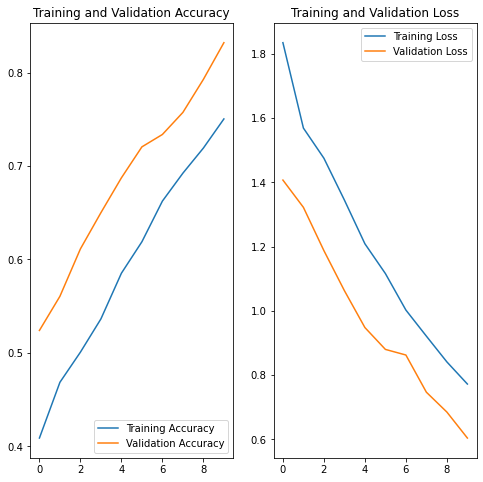

In [295]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [358]:
test_acc_round2 = model.evaluate(train)[1]

43/43 [==============================] - 97s 2s/step - loss: 0.6170 - accuracy: 0.8213


In [327]:
from sklearn.metrics import accuracy_score
import pandas as pd


evaluate = model.evaluate(test_generator)
print(evaluate)

#Accuracy with the test data
#print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

43/43 [==============================] - 104s 2s/step - loss: 0.6170 - accuracy: 0.8213
[0.6169901490211487, 0.8212984800338745]


In [337]:
pred = model.predict(test_generator)
pred =np.argmax(pred,axis=1)

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(30, 30))
    output.append(np.array(image))

X_test=np.array(output)

In [338]:
print(test_labels[1:10])

[ 1 38 33 11 38 18 12 25 35]


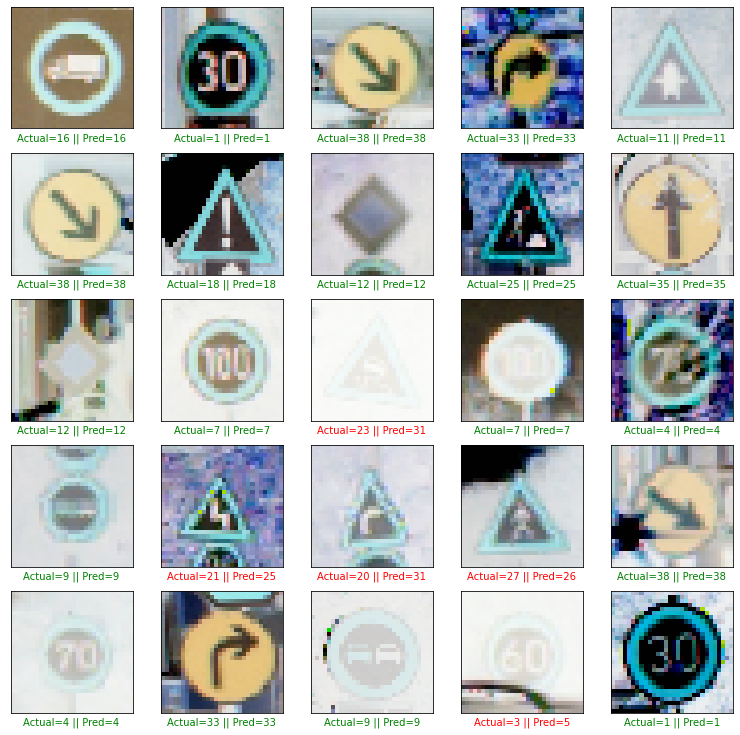

In [339]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow((X_test[start_index + i] * 255).astype(np.uint8))
plt.show()

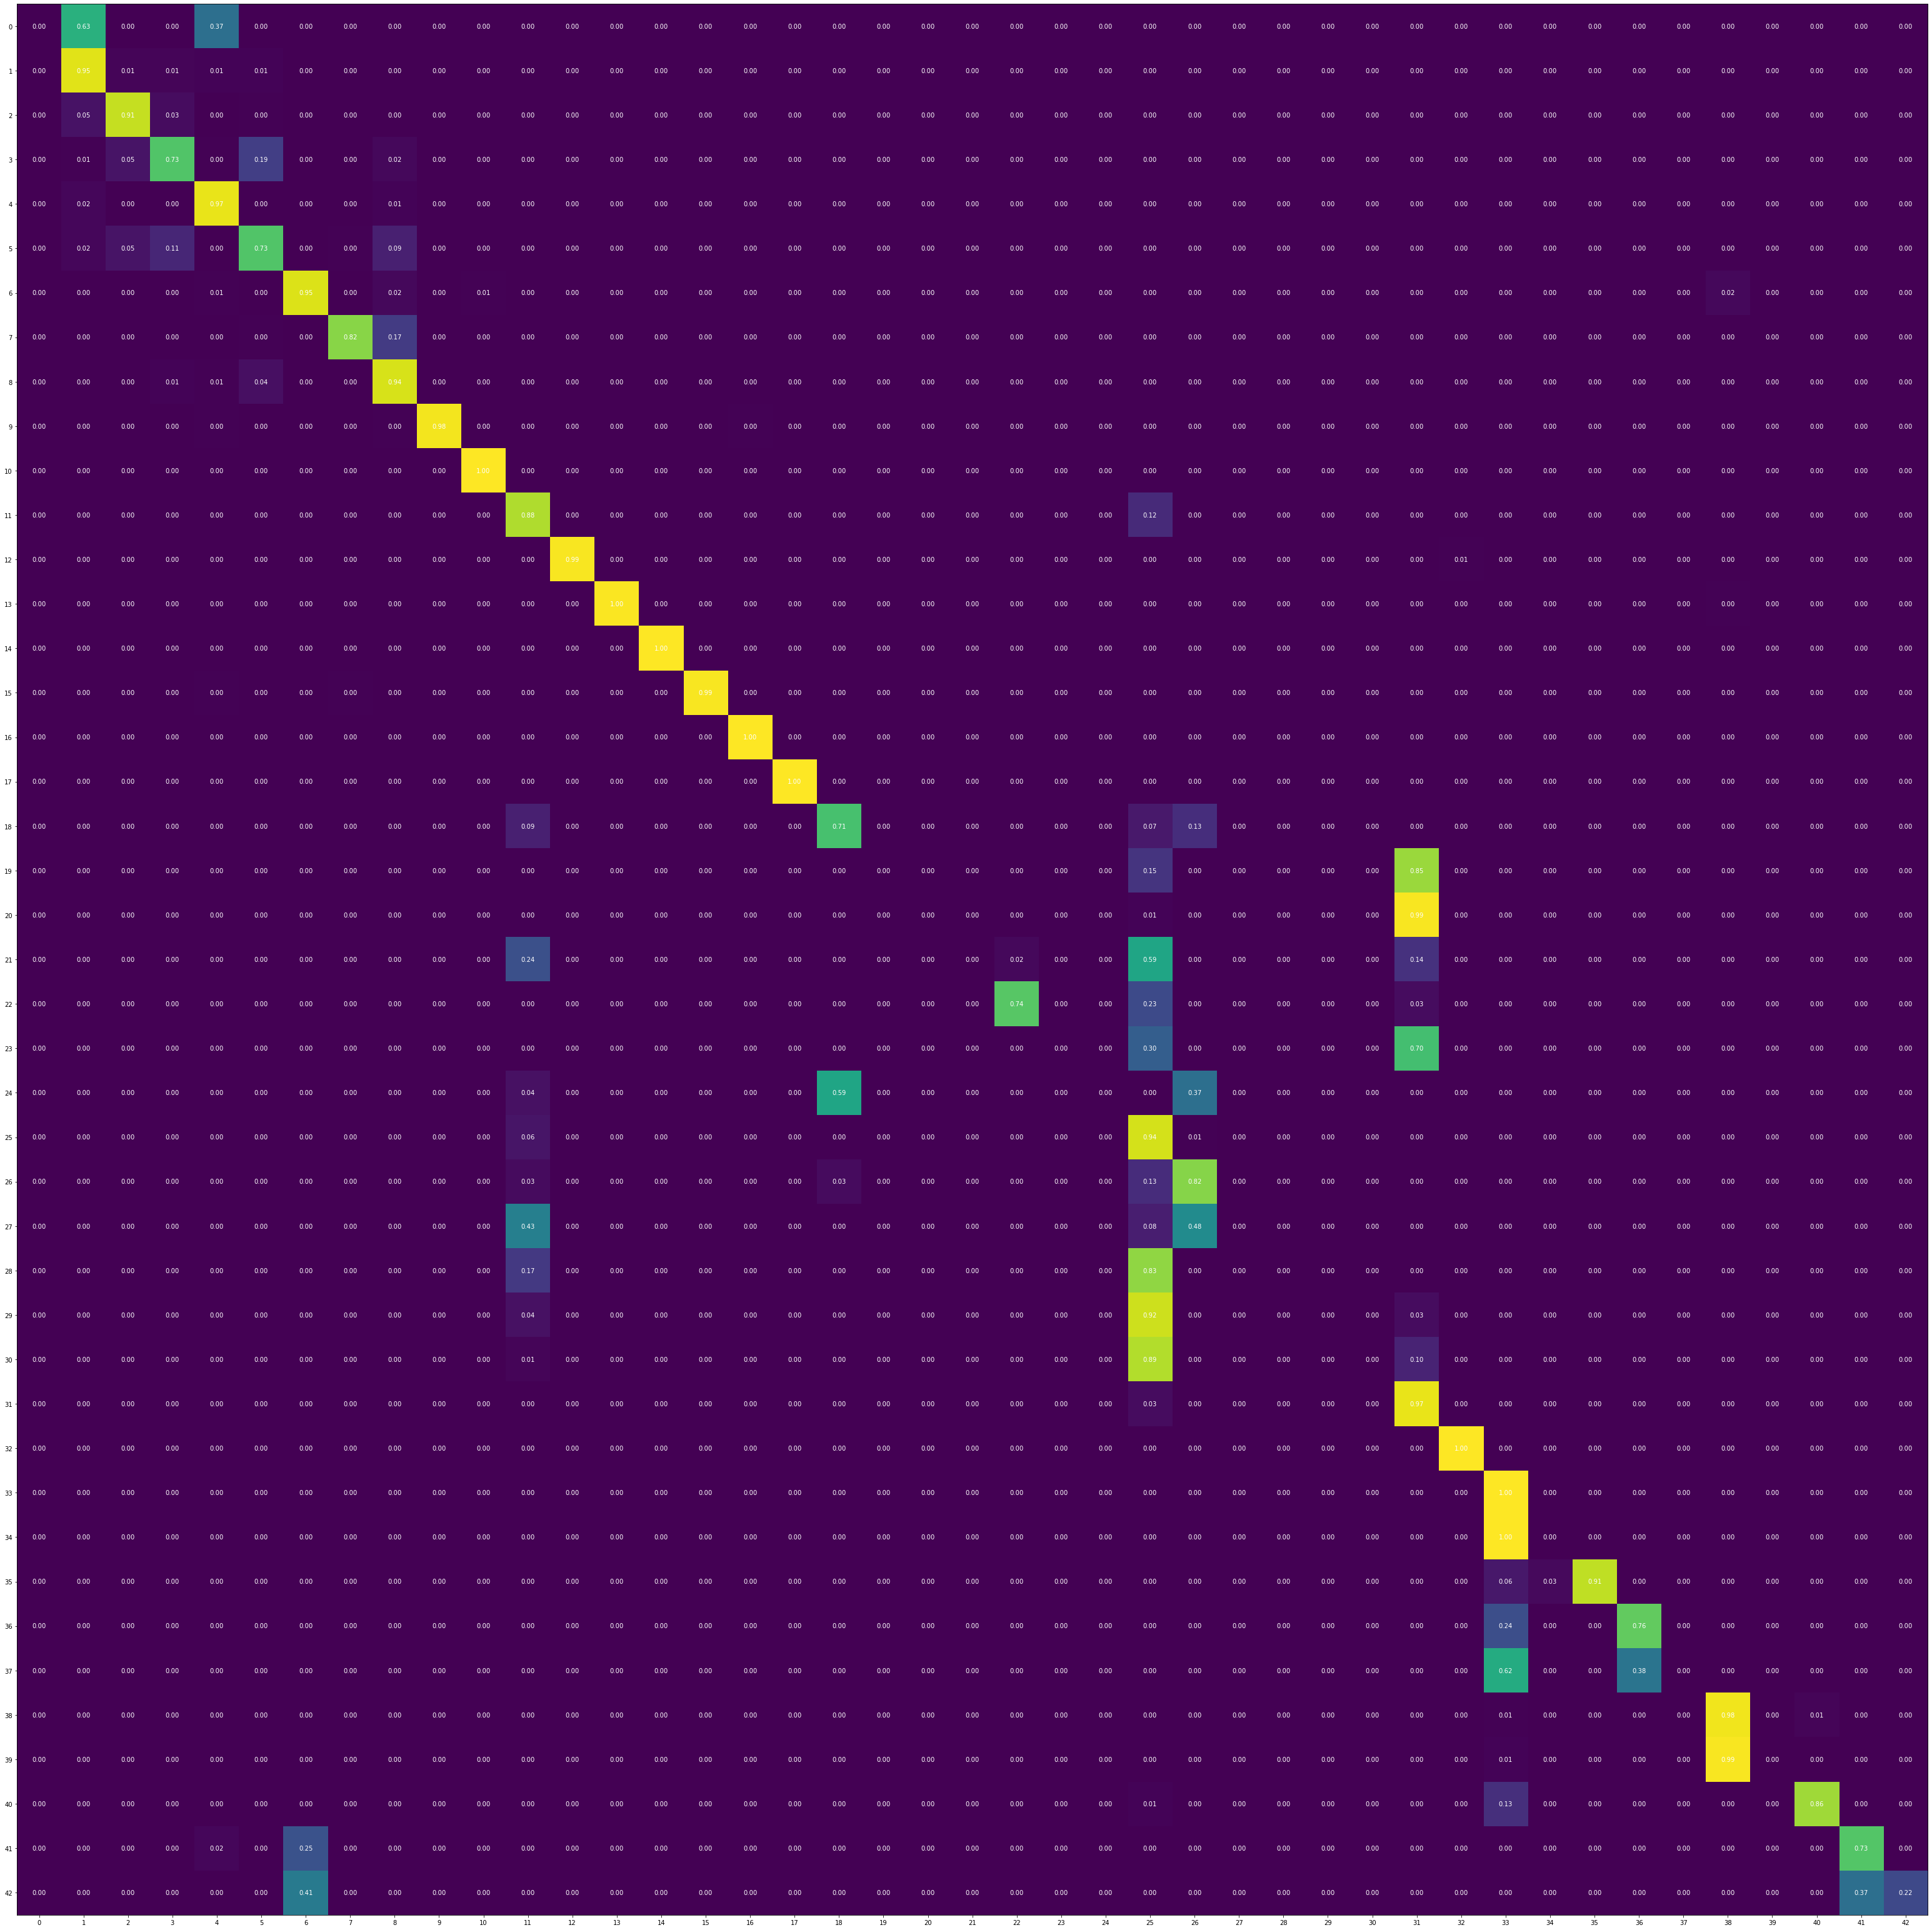

In [356]:
from sklearn.metrics import  confusion_matrix
from sklearn.preprocessing import normalize
classes = 43

conf_matrix = np.zeros((classes, classes))
for idx, prediction in enumerate(pred):
    row = test_labels[idx]
    col = prediction
    conf_matrix[row, col] += 1

# print(conf_matrix)
conf_matrix = normalize(conf_matrix, axis=1, norm='l1')
# print(conf_matrix)

plt.figure(figsize=(classes,classes))

plt.imshow(conf_matrix)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = plt.text(j, i, "{:.2f}".format(conf_matrix[i, j]), ha="center", va="center", color="w")

plt.xticks(range(classes), range(classes))
plt.yticks(range(classes), range(classes))

plt.tight_layout()
plt.show()     

In [360]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_labels, pred)))

print('Micro Precision: {:.2f}'.format(precision_score(test_labels, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(test_labels, pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(test_labels, pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(test_labels, pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(test_labels, pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(test_labels, pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(test_labels, pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(test_labels, pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(test_labels, pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_labels, pred, target_names=[
'Speed limit (20km/h)', 
'Speed limit (30km/h)', 
'Speed limit (50km/h)', 
'Speed limit (60km/h)', 
'Speed limit (70km/h)', 
'Speed limit (80km/h)',
'End of Speed limit (80km/h)', 
'Speed limit (100km/h)', 
'Speed limit (120km/h)',
'No passing', 
'No passing veh over 3.5 tons', 
'Right-of-way at intersection',
'Priority road', 
'Yield', 
'Stop', 
'No vehicles', 
'Veh > 3.5 tons prohibited',
'No entry', 
'General caution', 
'Dangerous curve left', 
'Dangerous curve right', 
'Double curve', 
'Bumpy road', 
'Slippery road', 
'Road narrows on the right',
'Road work', 
'Traffic signals', 
'Pedestrians', 
'Children crossing', 
'Bicycle crossing',
'Beware of ice/snow', 
'Wild animals crossing', 
'End speed + passing limits', 
'Turn right ahead', 
'Turn left ahead', 
'Ahead only', 
'Go straight or right', 
'Go straight or left', 
'Keep right', 
'Keep Left', 
'Roundabout mandatory',
'End of no passing', 
'End of no passing veh > 3.5 tons'
 ]))


Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82

Macro Precision: 0.59
Macro Recall: 0.62
Macro F1-score: 0.59

Weighted Precision: 0.78
Weighted Recall: 0.82
Weighted F1-score: 0.79

Classification Report

                                  precision    recall  f1-score   support

            Speed limit (20km/h)       0.00      0.00      0.00        60
            Speed limit (30km/h)       0.87      0.95      0.91       720
            Speed limit (50km/h)       0.91      0.91      0.91       750
            Speed limit (60km/h)       0.75      0.73      0.74       450
            Speed limit (70km/h)       0.94      0.97      0.95       660
            Speed limit (80km/h)       0.80      0.73      0.76       630
     End of Speed limit (80km/h)       0.73      0.95      0.83       150
           Speed limit (100km/h)       0.99      0.82      0.90       450
           Speed limit (120km/h)       0.73      0.94      0.82       450
                     

C:\Users\Myles-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Myles-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
